In [318]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [319]:
N_CLASSES = 2
N_FEATURES = 2
N_SAMPLES = 1000
np.random.seed(42)

os.makedirs('figs', exist_ok=True)
os.makedirs('data', exist_ok=True)

In [320]:
# Create joint distribution P(X,Y) where rows=classes, cols=features
data_distr = np.random.random((N_CLASSES,N_FEATURES))
data_distr = data_distr / data_distr.sum(axis=(0,1))  # Normalize to sum to 1

data_sample = []
for i in range(N_SAMPLES):
    xy = np.random.choice(N_FEATURES*N_CLASSES, p=data_distr.flatten())
    x = xy % N_FEATURES
    y = xy // N_FEATURES
    data_sample.append([x, y])
data_sample = np.array(data_sample)

data_sample_pd = pd.DataFrame(data_sample, columns=['X', 'Y'])
data_sample_pd.to_csv('data/data_sample.csv', index=False)

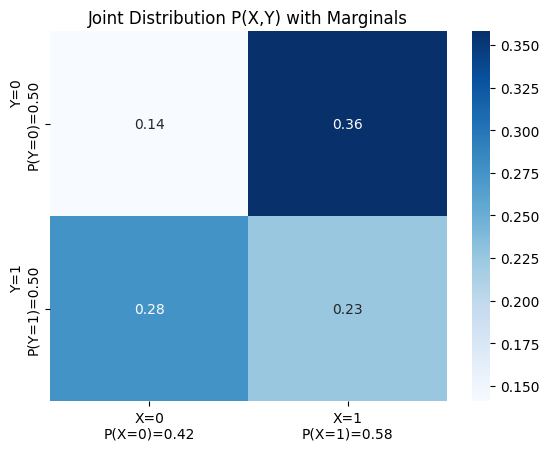

In [321]:
# Calculate marginal probabilities
p_x = data_distr.sum(axis=0)
p_y = data_distr.sum(axis=1)

# Create heatmap with marginal probabilities in labels
sns.heatmap(data_distr, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f'X=0\nP(X=0)={p_x[0]:.2f}', f'X=1\nP(X=1)={p_x[1]:.2f}'],
            yticklabels=[f'Y=0\nP(Y=0)={p_y[0]:.2f}', f'Y=1\nP(Y=1)={p_y[1]:.2f}'])
plt.title('Joint Distribution P(X,Y) with Marginals')
plt.savefig('figs/joint_table.png')
plt.show()

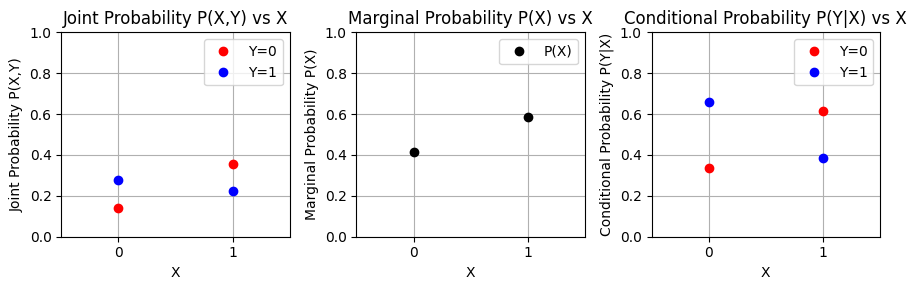

In [322]:
# Plot joint probabilities for each x value
COLORS = {0: 'red', 1: 'blue'}

def show(data_distr, ax, plot_type='joint', preds=None):
    x_values = np.arange(N_FEATURES)
    y_values = np.arange(N_CLASSES)

    if plot_type == 'joint':
        y_axis_label = 'Joint Probability P(X,Y)'
        for y in range(N_CLASSES):
            ax.plot(x_values, data_distr[y],'o', label=f'Y={y}', color=COLORS[y])
            if preds is not None:
                ax.plot(x_values, preds[y], '--', label=f'Pred Y={y}', color=COLORS[y])
    elif plot_type == 'marginal':
        y_axis_label = 'Marginal Probability P(X)'
        ax.plot(x_values, data_distr.sum(axis=0) / data_distr.sum(axis=(0,1)),'o', label=f'P(X)', color='black')
        if preds is not None:
            ax.plot(x_values, preds, '--', label=f'Pred P(X)', color='black')
    elif plot_type == 'conditional':
        y_axis_label = 'Conditional Probability P(Y|X)'
        for y in range(N_CLASSES):
            ax.plot(x_values, data_distr[y]/data_distr.sum(axis=0),'o', label=f'Y={y}', color=COLORS[y])
            if preds is not None:
                ax.plot(x_values, preds[y], '--', label=f'Pred Y={y}', color=COLORS[y])

    ax.set_xlabel('X')
    ax.set_ylabel(y_axis_label)
    ax.set_title(f'{y_axis_label} vs X')
    ax.legend()
    ax.grid(True)
    ax.set_xticks([0,1])
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0, 1)

# Example usage with subplots
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

show(data_distr, axes[0], plot_type='joint')
show(data_distr, axes[1], plot_type='marginal')
show(data_distr, axes[2], plot_type='conditional')

plt.tight_layout()
plt.savefig('figs/triple_plot.png')
plt.show()

# Train baseline

Epoch 9: 100%|██████████| 16/16 [00:00<00:00, 1066.95it/s]


Final classification loss: 0.659


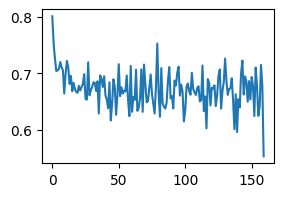

In [323]:
import torch
from tqdm import tqdm

model = torch.nn.Linear(1, 2)
dataloader = torch.utils.data.DataLoader(data_sample, batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
losses = []
for epoch in range(10):
    for batch in tqdm(dataloader, desc=f'Epoch {epoch}'):
        x, y = batch[:,0], batch[:,1]
        x = x.unsqueeze(1).float()
        y = y.unsqueeze(1).long()

        pred = model(x)

        loss = torch.nn.functional.cross_entropy(pred, y.flatten())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

print(f'Final classification loss: {np.mean(losses[-10:]):.3f}')
plt.figure(figsize=(3, 2))
plt.plot(losses)
plt.savefig('figs/loss.png')

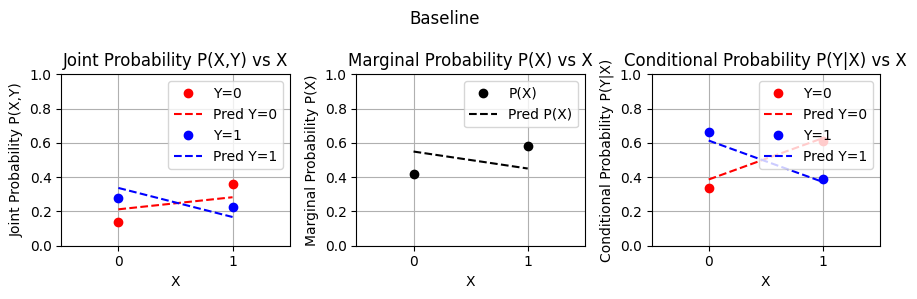

In [324]:
def show_model_properties(model, title=''):
    # Using the energy based interpretation that logits f(x,y) are -E(x,y)
    # P(x,y) = exp(-E(x,y)) / Z
    # P(x) = sum_y P(x,y)
    # P(y|x) = exp(-E(x,y)) / Z (softmax)

    with torch.no_grad():
        logits = model(torch.Tensor([[0],[1]]).float()) # Shape is (2,2) or (N_FEATURES, N_CLASSES)
        energy = -logits
        exps = torch.exp(-energy)
        pred_joint = exps / exps.sum(dim=(0,1))
        pred_cond = exps / exps.sum(dim=1, keepdim=True)
        pred_marginal = pred_joint.sum(dim=1)

    # Example usage with subplots
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    show(data_distr, axes[0], plot_type='joint', preds=pred_joint.numpy().squeeze().T)
    show(data_distr, axes[1], plot_type='marginal', preds=pred_marginal.numpy().squeeze())
    show(data_distr, axes[2], plot_type='conditional', preds=pred_cond.numpy().squeeze().T)

    fig.suptitle(title)
    plt.tight_layout()
    plt.savefig(f'figs/triple_plot_{title}.png')
    plt.show()

show_model_properties(model, title='Baseline')

# Train JEM

Epoch 9: 100%|██████████| 16/16 [00:00<00:00, 592.32it/s]


Final energy loss: 0.003
Final classification loss: 0.672
Final total loss: 0.675


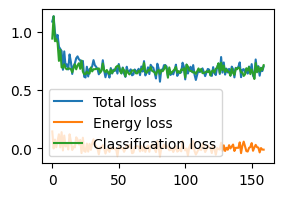

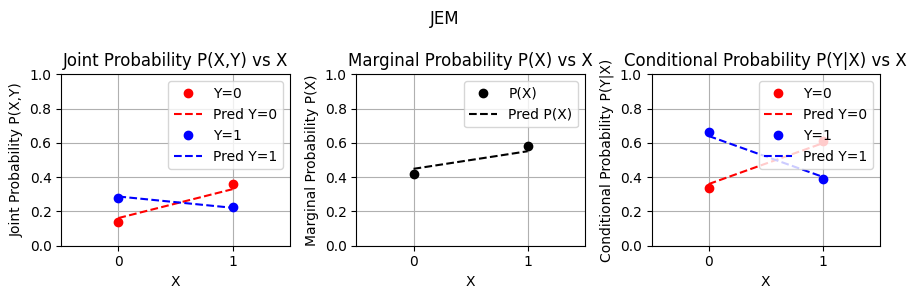

In [325]:
model = torch.nn.Linear(1, 2)
dataloader = torch.utils.data.DataLoader(data_sample, batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
losses = []
energy_losses = []
clf_losses = []
for epoch in range(10):
    for batch in tqdm(dataloader, desc=f'Epoch {epoch}'):
        x, y = batch[:,0], batch[:,1]
        x = x.unsqueeze(1).float()
        y = y.unsqueeze(1).long()

        logits_x = model(x)

        loss_clf = torch.nn.functional.cross_entropy(logits_x, y.flatten())

        # Sample an x proportional to the current model hypothesis
        with torch.no_grad():
            # first get model logits for both x values
            logits = model(torch.Tensor([[0],[1]]).float())
            energy = -logits
            exps = torch.exp(-energy)
            pred_joint = exps / exps.sum(dim=(0,1))
            pred_marginal = pred_joint.sum(dim=1) # P(x)

            # sample x from P(x)
            x_sample = np.random.choice(N_FEATURES, size=x.shape[0], p=pred_marginal.numpy().squeeze())
            x_sample = torch.Tensor([x_sample]).T

        energy_x = -torch.logsumexp(logits_x, dim=1)
        logits_x_sample = model(x_sample)
        energy_x_sample = -torch.logsumexp(logits_x_sample, dim=1)

        loss_energy = (energy_x - energy_x_sample).mean()

        loss = loss_clf + loss_energy

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        energy_losses.append(loss_energy.item())
        clf_losses.append(loss_clf.item())

print(f'Final energy loss: {np.mean(energy_losses[-10:]):.3f}')
print(f'Final classification loss: {np.mean(clf_losses[-10:]):.3f}')
print(f'Final total loss: {np.mean(losses[-10:]):.3f}')

plt.figure(figsize=(3, 2))
plt.plot(losses, label='Total loss')
plt.plot(energy_losses, label='Energy loss')
plt.plot(clf_losses, label='Classification loss')
plt.legend()
plt.show()

show_model_properties(model, title='JEM')